In [40]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()


True

In [41]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("practice")

LangSmith 추적을 시작합니다.
[프로젝트명]
practice


In [70]:
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

# Step 1: FAISS 인덱스 파일 로드
faiss_index_path = "naver_map_faiss"  # 저장된 Faiss 파일 경로
embeddings = OpenAIEmbeddings()  # 임베딩 객체 초기화

# 저장된 FAISS 인덱스를 불러와서 Retriever 생성
retriever_navermap = FAISS.load_local(faiss_index_path, embeddings,allow_dangerous_deserialization=True).as_retriever()

# 검색 매개변수 설정 (예: 검색 결과 상위 10개 반환)
retriever_navermap.search_kwargs = {"k": 5}

In [81]:
retriever_navermap.invoke("용산구")

[Document(id='993883e1-33a5-4b16-8052-fc661adfe4d0', metadata={'store_name': '어슬 서울', 'category': '한식', 'new_open': ' ', 'rating': '정보없음', 'visited_review': '방문자 리뷰 23', 'directions_text': '서울역 7번출구에서 나오셔서\n연세대학교 세브란스빌딩이 왼쪽에 보이실거에요.\n그대로 80m 이동하시면 왼쪽에 건물입구가 있습니다.\n\n회현역 5번출구에서 남대문시장 입구 교차로 쪽으로 나오시면\n우리농산물유통센터 남대문점이 있습니다.\n오른쪽 방향으로 200m정도 이동하시면 오른쪽에 건물입구가 있습니다.\n\n어슬 서울은\n그랜드센트럴, 메트로타워, 서울로타워, SK텔레콤 남산사옥 건물 가운데쪽에 위치하고 있습니다.\n\n숭례문광장에서 오실경우 도보 5분정도 소요됩니다.\n\n13층으로 올라오시면 다양한 전통주와 다채로운 퓨전한식이 준비되어 있는 어슬 서울이 있습니다.\n\n서울역 회식, 연말모임, 송년회, 신년회, 데이트, 기념일 등 중요한 순간에 어슬 서울과 함께 하세요!\n내용 더보기', 'store_id': '1059606805', 'address': '서울 중구 퇴계로 15 13층', 'blog_review': '블로그 리뷰 35', 'phone_num': '0507-1415-8725', 'business_hours': '일\n11:30 - 23:00\n15:00 - 17:00 브레이크타임\n21:30 라스트오더\n월\n11:30 - 23:00\n15:00 - 17:00 브레이크타임\n21:30 라스트오더\n화\n11:30 - 23:00\n15:00 - 17:00 브레이크타임\n21:30 라스트오더\n수\n11:30 - 23:00\n15:00 - 17:00 브레이크타임\n21:30 라스트오더\n목\n11:30 - 23:00\n15:00 - 17:00 브레이크타임\n21:30 라스트오더\n금\n11:30 - 23:0

In [44]:
# Step 1: FAISS 인덱스 파일 로드
faiss_index_path = "faiss_opendata_index_combined"  # 저장된 Faiss 파일 경로
embeddings = OpenAIEmbeddings()  # 임베딩 객체 초기화

# 저장된 FAISS 인덱스를 불러와서 Retriever 생성
retriever_opendata = FAISS.load_local(faiss_index_path, embeddings,allow_dangerous_deserialization=True).as_retriever()

# 검색 매개변수 설정 (예: 검색 결과 상위 10개 반환)
retriever_opendata.search_kwargs = {"k": 10}

In [45]:
context = retriever_opendata.invoke(' 주소가 강남구의 카페 5개를 알려줘')
context

[Document(id='510de583-24e7-4dbb-94ae-602ef7410bce', metadata={'최종 표기명': '압구정카페골목', '지번 주소': '서울시 강남구 압구정동 일대', '중심 좌표 X': 127.029231648, '중심 좌표 Y': 37.5238250318}, page_content='최종 표기명: 압구정카페골목 \n 지번 주소: 서울시 강남구 압구정동 일대 \n 중심 좌표 X: 127.029231648 \n 중심 좌표 Y: 37.5238250318'),
 Document(id='42483fff-048e-472c-b14a-7cfb5137d6a3', metadata={'상호명': '무네이 카페', '콘텐츠URL': 'https://korean.visitseoul.net/restaurants/무네이-카페/KOP039732?utm_source=seoulopendata&utm_medium=restaurants&utm_content=KOP039732', '주소': ' 서울 중구 인현동1가 114-2 ', '신주소': '04556 서울 중구 마른내로4길 11 (인현동1가) ', '전화번호': '070-7769-0331', '웹사이트': nan, '운영시간': '12:00~21:00', '교통정보': '2,3호선 을지로3가역 8번 출구에서 약 225m (도보 3분)', '홈페이지 언어': nan, '대표메뉴': '무네이라떼 6,000원 아이스톤 7,000원 브루잉 6,000원'}, page_content='상호명: 무네이 카페 \n 콘텐츠URL: https://korean.visitseoul.net/restaurants/무네이-카페/KOP039732?utm_source=seoulopendata&utm_medium=restaurants&utm_content=KOP039732 \n 주소:  서울 중구 인현동1가 114-2  \n 신주소: 04556 서울 중구 마른내로4길 11 (인현동1가)  \n 전화번호: 070-7769-0331 \n 웹사

In [46]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI


# Query Rewrite 프롬프트 정의
re_write_prompt = PromptTemplate(
    template="""Reformulate the given question to enhance its effectiveness for vectorstore retrieval.

- Analyze the initial question to identify areas for improvement such as specificity, clarity, and relevance.
- Consider the context and potential keywords that would optimize retrieval.
- Maintain the intent of the original question while enhancing its structure and vocabulary.

# Steps

1. **Understand the Original Question**: Identify the core intent and any keywords.
2. **Enhance Clarity**: Simplify language and ensure the question is direct and to the point.
3. **Optimize for Retrieval**: Add or rearrange keywords for better alignment with vectorstore indexing.
4. **Review**: Ensure the improved question accurately reflects the original intent and is free of ambiguity.

# Output Format

- Provide a single, improved question.
- Do not include any introductory or explanatory text; only the reformulated question.

# Examples

**Input**: 
"What are the benefits of using renewable energy sources over fossil fuels?"

**Output**: 
"How do renewable energy sources compare to fossil fuels in terms of benefits?"

**Input**: 
"How does climate change impact polar bear populations?"

**Output**: 
"What effects does climate change have on polar bear populations?"

# Notes

- Ensure the improved question is concise and contextually relevant.
- Avoid altering the fundamental intent or meaning of the original question.


[REMEMBER] Re-written question should be in the same language as the original question.

# Here is the original question that needs to be rewritten:
{question}
""",
    input_variables=["generation", "question"],
)

question_rewriter = (
    re_write_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser()
)

In [47]:
from typing import Annotated, TypedDict, List
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[List[str], add_messages]  # 질문(누적되는 list)
    context_naver: Annotated[str, "Context"]  # 문서의 검색 결과
    context_opendata: Annotated[str, "Context"]  # 문서의 검색 결과
    context_web: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)
    webOrRetriever: Annotated[str, "webOrRetriever"]  # 관련성

In [62]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from operator import itemgetter
# 프롬프트
prompt = PromptTemplate(
    template="""너는  {context_opendata}, {context_naver}의 데이터를 종합해서 서울의 관광 일정을 추천해주는 봇이야.
    사용자의 질문에 따라서 여러가지 서울의 관광지, 식당, 숙소, 쇼핑몰 등을 추천해야해.
    처음에 사용자가 서울에 며칠동안 머무르는지 물어보고, 그에 따라서 관광 일정을 추천해주면 돼.
    그 다음 사용자가 서울에 오는 이유에 대해 파악하고 그에 맞는 여행 일정을 추천해주면 돼.
    대화하다가 추천한 여행 일정이 사용자의 마음에 들지 않아서 변경해달라고 하면 마음에 들지 않은 부분을
    캐치하고 그 부분들만 수정해서 다시 추천해주면 돼.
    일정 중간 중간 숙소나 식당, 쇼핑몰 등을 추천해주면 돼.
    답변은 너무 길지 않게 5000자 이내로 알려줘

    어떤 장소가 궁금해서 물어본다면 특정 장소의 정보들을 정확하게 알려줘.
    (예:가게 정보, 메뉴, 별점, 위치, 연락처, 운영 시간, 리뷰 등)
    여행 일정에 대한 동선이 짧도록 추천해줘.
    언어는 사용자가 입력한 언어를 기준으로 알려줘. 
    화폐 기준도 사용자가 입력한 언어를 사용하는 국가의 화폐를 기준으로 적용해줘.




    # opendata 정보: {context_opendata}

    # naver 지도 : {context_naver}

    #사용자의 질문: {question}
    
    #이전 대화 내용 {chat_history} 
    """,
        input_variables=["context_opendata","context_naver", "question"],
    )
#input_variables=["context_web","context_opendata","context_naver", "question"],
    # 웹 검색 정보 : {context_web}
# LLM
model = ChatOpenAI(model_name="gpt-4o",
                    temperature=0, streaming=True)

chain = (
    {
        "question": itemgetter("question"),
        # "context_web": itemgetter("context_web"),
        "context_opendata": itemgetter("context_opendata"),
        "context_naver": itemgetter("context_naver"),
        "chat_history": itemgetter("chat_history"),
    }
    | prompt
    | model
    | StrOutputParser()
)

In [49]:
prompt_Web_or_retriever = PromptTemplate(
    template=""" 너는 사용자의 질문에 대해서 두가지의 옵션으로 대답하는 봇이야.
    너의 대답은 'web', 'retriever' 두가지로만 대답할 수 있어.
    사용자가 질문을 하면 문맥을 잘 살펴서 웹에서 정보를 검색하기를 원하면 'web' 이라고 대답해야돼.
    그렇지 않으면 'retriever' 를 출력해줘. 

    #대답 형식 : 'web' or 'retriever'

    #사용자의 질문: {question}
    

    """,
        input_variables=["question"],
    )
model_web_check = ChatOpenAI(model_name="gpt-4o",
                    temperature=0, streaming=True)

chain_Web_or_retriever = (
    {
        "question": itemgetter("question"),
    }
    | prompt_Web_or_retriever
    | model_web_check
    | StrOutputParser()
)

In [50]:
prompt_web = PromptTemplate(
    template="""너는 웹 검색을 통한 {context_web}의 내용를 종합해서 서울시의 중구,종로구,용산구,강남구 관광 일정을 추천해주는 봇이야.
    사용자의 질문에 따라서 여러가지 서울의 관광지, 식당, 숙소, 쇼핑몰 등을 추천해야해.
    처음에 사용자가 서울에 며칠동안 머무르는지 물어보고, 그에 따라서 관광 일정을 추천해주면 돼.
    그 다음 사용자가 서울에 오는 이유에 대해 파악하고 그에 맞는 여행 일정을 추천해주면 돼.
    대화하다가 추천한 여행 일정이 사용자의 마음에 들지 않아서 변경해달라고 하면 마음에 들지 않은 부분을
    캐치하고 그 부분들만 수정해서 다시 추천해주면 돼.
    일정 중간 중간 숙소나 식당, 쇼핑몰 등을 추천해주면 돼.

    어떤 장소가 궁금해서 물어본다면 특정 장소의 정보들을 정확하게 알려줘.
    (예:가게 정보, 메뉴, 별점, 위치, 연락처, 운영 시간, 리뷰 등)
    여행 일정에 대한 동선이 짧도록 추천해줘.
    언어는 사용자가 입력한 언어를 기준으로 알려줘. 
    화폐 기준도 사용자가 입력한 언어를 사용하는 국가의 화폐를 기준으로 적용해줘.


    - 너가 제공한 내용의 출처를 링크로 남겨줘

    # 웹 검색 정보 : {context_web}

    #사용자의 질문: {question}
    
    #이전 대화 내용 {chat_history} 
    """,
        input_variables=["context_web", "question"],
    )
#input_variables=["context_web","context_opendata","context_naver", "question"],
# LLM
model_web = ChatOpenAI(model_name="gpt-4o",
                    temperature=0, streaming=True)

chain_web = (
    {
        "question": itemgetter("question"),
        "context_web": itemgetter("context_web"),
        # "context_opendata": itemgetter("context_opendata"),
        # "context_naver": itemgetter("context_naver"),
        "chat_history": itemgetter("chat_history"),
    }
    | prompt_web
    | model_web
    | StrOutputParser()
)

In [63]:
from langchain_teddynote.messages import messages_to_history
from langchain_teddynote.tools.tavily import TavilySearch

# from rag.utils import format_docs
# 웹 검색 or 리트리버 검색
def web_or_retriever_check(state: GraphState) -> GraphState:
    # 관련성 체크를 실행("yes" or "no")
    response = chain_Web_or_retriever.invoke(
        {"question": state["question"][-1].content}
    )

    return {"webOrRetriever": response}

# 웹 리트리버 분기 체크하는 함수(router)
def is_web(state: GraphState) -> GraphState:
    if state["webOrRetriever"] == "web":
        return "web"
    else:
        return "retriever"
    
# 문서 검색 노드
def retrieve_document_naver(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = retriever_navermap.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = "\n".join(
        [
            f"<document><content>{doc.page_content}</content>"
            for doc in retrieved_docs
        ]
)

    # 검색된 문서를 context 키에 저장합니다.
    return {"context_naver": retrieved_docs}

def retrieve_document_opendata(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = retriever_opendata.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = "\n".join(
        [
            f"<document><content>{doc.page_content}</content>"
            for doc in retrieved_docs
        ]
)

    # 검색된 문서를 context 키에 저장합니다.
    return {"context_opendata": retrieved_docs}


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content
    # 검색된 문서를 상태에서 가져옵니다.
    context_naver = state["context_naver"]
    context_opendata = state["context_opendata"]
    #context_web = state["context_web"]

    # 체인을 호출하여 답변을 생성합니다.
    response = chain.invoke(
        {
            "question": latest_question,
           # "context_web": context_web,
            "context_naver": context_naver,
            "context_opendata": context_opendata,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    print(state["messages"])
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    } 

# 웹 검색 답변 생성 노드
def llm_answer_web(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"][-1].content
    # 검색된 문서를 상태에서 가져옵니다.
    # context_naver = state["context_naver"]
    # context_opendata = state["context_opendata"]
    context_web = state["context_web"]

    # 체인을 호출하여 답변을 생성합니다.
    response = chain_web.invoke(
        {
            "question": latest_question,
            "context_web": context_web,
            # "context_naver": context_naver,
            # "context_opendata": context_opendata,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    print(state["messages"])
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

# Web Search 노드
def web_search(state: GraphState) -> GraphState:
    # 검색 도구 생성
    tavily_tool = TavilySearch()

    search_query = state["question"][-1].content

    # 다양한 파라미터를 사용한 검색 예제
    search_result = tavily_tool.search(
        query=search_query,  # 검색 쿼리
        topic="general",  # 일반 주제
        max_results=2,  # 최대 검색 결과
        format_output=True,  # 결과 포맷팅
    )

    return {"context_web": search_result}


def query_rewrite(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    question_rewritten = question_rewriter.invoke({"question": latest_question})
    return {"question": question_rewritten}

In [64]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve_opendata", retrieve_document_opendata)
workflow.add_node("retrieve__naver", retrieve_document_naver)
workflow.add_node("query_rewrite", query_rewrite)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("llm_answer_web", llm_answer_web)
workflow.add_node("web_search", web_search)
workflow.add_node("web_Or_Retriever", web_or_retriever_check)

# 엣지 정의
workflow.add_conditional_edges(
    "web_Or_Retriever",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_web,
    {
        "web": "web_search",  # 웹 검색을 요청하면 웹검색을 합니다
        "retriever": "query_rewrite",  # 아니면 리트리버
    },
)

workflow.add_edge("query_rewrite", "retrieve_opendata")  # 검색 -> 답변
#workflow.add_edge("query_rewrite", "web_search")  # 질문 -> 검색
workflow.add_edge("query_rewrite", "retrieve__naver")  # 질문 -> 검색
workflow.add_edge("web_search", "llm_answer_web")  
workflow.add_edge("retrieve_opendata", "llm_answer") 
workflow.add_edge("retrieve__naver", "llm_answer") 
workflow.add_edge("llm_answer", END)  # 답변 -> 종료
workflow.add_edge("llm_answer_web", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("web_Or_Retriever")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

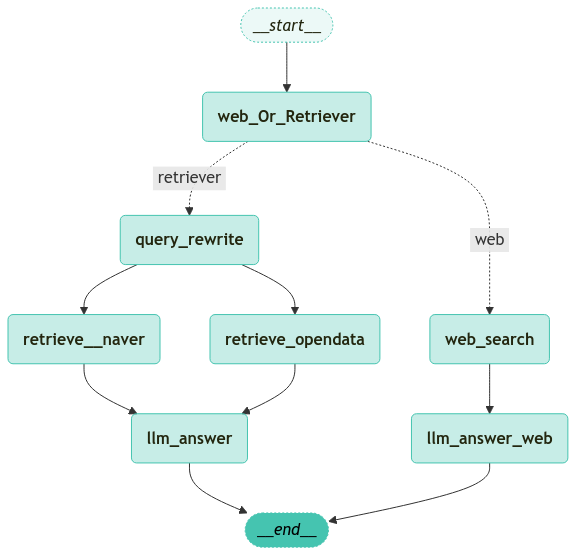

In [65]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [66]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

In [78]:
inputs = GraphState(question="내가 직전에 한 질문이 뭐였지")

In [79]:
res=app.invoke(input=inputs, config=config)

[HumanMessage(content='종로구에서 1박 2일 여행 일정을 추천해 줄 수 있나요?', additional_kwargs={}, response_metadata={}, id='af83e222-371a-4ecf-9889-ab58886ca325'), AIMessage(content='종로구에서의 1박 2일 여행 일정을 추천해드릴게요. 종로구는 서울의 역사와 문화를 느낄 수 있는 곳으로, 다양한 관광 명소와 맛집이 많습니다. 아래는 추천 일정입니다.\n\n### 1일차\n\n**오전**\n- **북촌한옥마을**: 전통 한옥이 모여 있는 북촌한옥마을을 산책하며 한국의 전통 건축을 감상하세요. 사진 찍기 좋은 장소입니다.\n- **전통공예체험관**: 북촌한옥마을 근처에 위치한 전통공예체험관에서 한국 전통 공예를 체험해보세요. (운영시간: 10:00~18:00)\n\n**점심**\n- **쌈지길 체험공방**: 인사동에 위치한 쌈지길에서 다양한 공예품을 구경하고, 인근 식당에서 전통 한식을 즐겨보세요. (운영시간: 10:30~20:30)\n\n**오후**\n- **경복궁**: 한국의 대표적인 궁궐인 경복궁을 방문하여 조선시대의 역사를 느껴보세요. 경복궁 근처에는 국립민속박물관도 있어 함께 방문하기 좋습니다.\n- **인사동 거리**: 전통과 현대가 어우러진 인사동 거리에서 다양한 전통 공예품과 기념품을 구경하세요.\n\n**저녁**\n- **우리집 게스트하우스**: 종로구 계동에 위치한 우리집 게스트하우스에서 편안한 휴식을 취하세요. (운영시간: 24시간)\n\n### 2일차\n\n**오전**\n- **서울김치문화체험관**: 명동에 위치한 서울김치문화체험관에서 김치 만들기 체험을 해보세요. (운영시간: 10:30~19:00)\n\n**점심**\n- **연서네 철문집**: 서울역 근처에 위치한 연서네 철문집에서 맛있는 삼겹살을 즐기세요. (운영시간: 15:00~03:00)\n\n**오후**\n- **청계천 헌책방 거리**: 을지로에 위치한 청계천 헌책방 거리에서

In [80]:
res

{'question': [HumanMessage(content='종로구에 1박2일 여행 일정을 만들어 줄 수 있어?', additional_kwargs={}, response_metadata={}, id='5e4805ad-054a-48bd-8fbb-dba4f26150aa'),
  HumanMessage(content='종로구에서 1박 2일 여행 일정을 어떻게 구성할 수 있을까?', additional_kwargs={}, response_metadata={}, id='9c4cc664-808b-47fb-bf8e-1d6a045fe175'),
  HumanMessage(content='종로구에 1박2일 여행 일정을 만들어 줄 수 있어?', additional_kwargs={}, response_metadata={}, id='50f84474-5700-4423-bc20-794b9630ade4'),
  HumanMessage(content='종로구에서 1박 2일 여행 일정을 추천해 줄 수 있나요?', additional_kwargs={}, response_metadata={}, id='164828ac-71c4-46e8-89f5-e2a08f3f0713'),
  HumanMessage(content='이번에는 용산구와 중구에서의 일정을 만들어줘', additional_kwargs={}, response_metadata={}, id='5293615c-ab42-4eba-aec0-075bab855fd2'),
  HumanMessage(content='용산구와 중구에서의 일정 계획을 어떻게 세울 수 있을까요?', additional_kwargs={}, response_metadata={}, id='7dce6d2f-d201-4294-bc8d-9c44e1e46f51'),
  HumanMessage(content='내가 직전에 한 질문이 뭐였지', additional_kwargs={}, response_metadata={}, id='1169dd59-6f0e-4870-a823-77bb497

In [76]:
print(res.get('answer'))

용산구와 중구에서의 일정 계획을 세워드릴게요. 두 지역은 서울의 중심부에 위치해 있어 다양한 문화와 역사를 경험할 수 있는 곳입니다. 아래는 추천 일정입니다.

### 1일차: 용산구

**오전**
- **국립중앙박물관**: 한국의 역사와 문화를 깊이 있게 이해할 수 있는 국립중앙박물관을 방문하세요. 다양한 전시와 유물들이 있습니다. (운영시간: 10:00~18:00)

**점심**
- **이태원**: 다양한 국제 요리를 즐길 수 있는 이태원에서 점심을 드세요. 여러 나라의 음식을 맛볼 수 있는 곳입니다.

**오후**
- **용산 전쟁기념관**: 한국 전쟁의 역사를 배울 수 있는 전쟁기념관을 방문하세요. (운영시간: 09:00~18:00)
- **성수미술관 용산점**: 삼각지역 근처에 위치한 성수미술관에서 드로잉 체험을 즐기며 여유로운 시간을 보내세요. (운영시간: 12:00~21:30)

**저녁**
- **남산타워**: 서울의 야경을 감상할 수 있는 남산타워를 방문하세요. 케이블카를 타고 올라가면 더욱 특별한 경험이 될 것입니다.

### 2일차: 중구

**오전**
- **덕수궁**: 조선 시대의 궁궐인 덕수궁을 방문하여 한국의 전통 건축을 감상하세요. (운영시간: 09:00~18:00)

**점심**
- **죽이야기 서울 중구소공점**: 건강한 한식을 제공하는 죽이야기에서 전복죽이나 다양한 죽 메뉴를 즐기세요. (운영시간: 08:00~16:00)

**오후**
- **명동 쇼핑 거리**: 다양한 브랜드와 상점이 모여 있는 명동에서 쇼핑을 즐기세요.
- **청계천 헌책방 거리**: 을지로에 위치한 청계천 헌책방 거리에서 다양한 헌책과 독특한 아이템을 구경하세요.

**저녁**
- **어슬 서울**: 서울역 근처에 위치한 어슬 서울에서 퓨전 한식과 전통주를 즐기며 하루를 마무리하세요. (운영시간: 11:30~23:00)

이 일정은 용산구와 중구의 주요 명소를 중심으로 구성되었습니다. 각 장소의 운영 시간과 위치를 확인하시고, 이동 시간을 고려하여 일정을

In [30]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="용산구에 1박2일을 머물거야 일정을 검색해서 알려줘")

# 그래프 실행
invoke_graph(app, inputs, config)


🔄 Node: web_Or_Retriever 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
webOrRetriever:
web

🔄 Node: web_search 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<document><title>서울 용산구 여행 정보: 꼭 가봐야할 곳 추천 리스트 & 여행 후기 | 익스피디아</title><url>https://www.expedia.co.kr/Seoul-Yongsan-Gu.dx179262</url><content>숙소 위치, 가볼 만한 곳, 놀거리 등 서울 용산구 여행을 최대한으로 즐기기 위해 필요한 모든 여행 정보를 지금 익스피디아에서 확인하세요!</content><raw>회원은 로그인 시 전 세계 10만여 개 호텔 10% 이상 할인
용산구
용산구 여행 정보
가볼 만한 인기 명소
서울에서 웬만한 곳이면 저 멀리서도 보이는 이 서울의 명소는 서울 시내를 한눈에 내려다볼 수 있는 전망을 자랑하지요.
남산공원을 방문해 넓게 펼쳐져 있는 이 산속 공원의 평화로운 자연 환경을 걸어서 탐방하고 케이블카를 타거나 서울의 멋진 스카이라인을 구경해 보세요.
수천 점의 유물과 우리 문화재 등을 소장하고 있는 국립중앙박물관에서 자연광이 들어오는 현대적인 전시실을 둘러보세요.
서울 여행 중 이태원 거리에 들러 쇼핑을 즐기며 스트레스를 날려보세요. 걷기 좋은 이곳에서 최고급 레스토랑에 들러 현지의 맛을 느껴보시는 걸 추천해 드려요. 
전쟁기념관에서 우리나라의 전쟁 역사에 대해 알아보고 방대한 군수 물품 전시를 감상하며 호국선열에 묵상하는 시간도 가져보세요.
서울 중앙성원에 방문하여 서울의 역사에 대해 배워보세요. 가족끼리 머물기 좋은 이곳에서 강변에 들러 한가로이 거닐어도 좋고 최고급 레스토랑에서 식도락 여행을 즐길 수도 있어요. 
용산구의 인기 호텔
후기 작성 날짜: 2025년 1월 2일
후기 작성 날짜: 2024년 12월 12일
후기 작